In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import cv2
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Sequential
#from sklearn.model_selection import train_test_split

In [2]:
X_disp = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\dataset\main_matlab\256\new_inputs\disp_200"
X_temp = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\dataset\main_matlab\256\new_inputs\temp_200"
Y =r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\dataset\CIRCULAR_VANE_Images_240220\200_vanes\200_vanes"

In [3]:
X_train = np.zeros((190, 256, 256, 2))
Y_train = np.zeros((190, 256, 256, 1))
X_test = np.zeros((10,256,256,2))
Y_test = np.zeros((10,256,256,1))

In [4]:
for index, (disp_file, temp_file, vane_file) in enumerate(zip(os.listdir(X_disp)[:190], os.listdir(X_temp)[:190], os.listdir(Y)[:190])):
  disp_path = os.path.join(X_disp, disp_file)
  temp_path = os.path.join(X_temp, temp_file)
  vane_path = os.path.join(Y, vane_file)
  disp_img = imread(disp_path)
  temp_img = imread(temp_path)
  vane_img = imread(vane_path)
  disp_img = disp_img/0.5-1
  temp_img = temp_img/0.5-1
  vane_img = np.mean(vane_img, axis=2)
  vane_img = vane_img/127.5-1
  vane_img = np.reshape(vane_img, (256, 256, 1))
  disp_img = np.reshape(disp_img, (256, 256, 1))
  temp_img = np.reshape(temp_img, (256, 256, 1))
  Y_train[index] = vane_img
  X_train[index] = np.concatenate((disp_img, temp_img), axis=2)

In [5]:
for index, (disp_file, temp_file, vane_file) in enumerate(zip(os.listdir(X_disp)[190:200], os.listdir(X_temp)[190:200], os.listdir(Y)[190:200])):
  disp_path = os.path.join(X_disp, disp_file)
  temp_path = os.path.join(X_temp, temp_file)
  vane_path = os.path.join(Y, vane_file)
  disp_img = imread(disp_path)
  temp_img = imread(temp_path)
  vane_img = imread(vane_path)
  disp_img = disp_img/0.5-1
  temp_img = temp_img/0.5-1
  vane_img = np.mean(vane_img, axis=2)
  vane_img = vane_img/127.5-1
  vane_img = np.reshape(vane_img, (256, 256, 1))
  disp_img = np.reshape(disp_img, (256, 256, 1))
  temp_img = np.reshape(temp_img, (256, 256, 1))
  Y_test[index] = vane_img
  X_test[index] = np.concatenate((disp_img, temp_img), axis=2)

In [6]:
X_test.shape

(10, 256, 256, 2)

In [7]:
X_train.shape

(190, 256, 256, 2)

In [8]:
Y_train.shape

(190, 256, 256, 1)

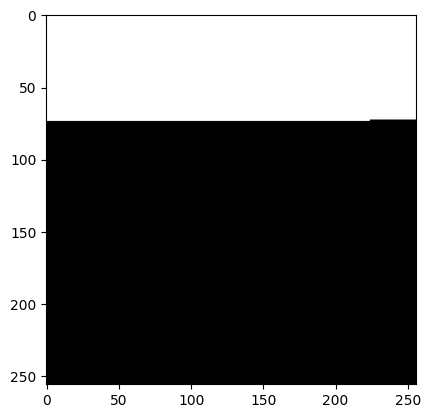

In [9]:
plt.imshow(X_train[5,:,:,0], cmap='gray')

In [10]:
#X_train1, X_test, y_train1, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [11]:
def encoder_block(input,filters,batch_norm=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  x=tf.keras.layers.Conv2D(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  if batch_norm:
    x=tf.keras.layers.BatchNormalization()(x,training=True)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  return x

def decoder_block(input,skip_con,filters,dropout=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  x=tf.keras.layers.Conv2DTranspose(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  x=tf.keras.layers.BatchNormalization()(x,training=True)
  if dropout:
    x=tf.keras.layers.Dropout(0.5)(x,training=True)
  x=tf.keras.layers.Concatenate()([x,skip_con])
  x=tf.keras.layers.ReLU()(x)
  return x

def generator_model(input_shape=(256,256,2)):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  input=tf.keras.layers.Input(input_shape)
  e1=encoder_block(input,64,batch_norm=False)
  e2=encoder_block(e1,128)
  e3=encoder_block(e2,256)
  e4=encoder_block(e3,512)
  e5=encoder_block(e4,512)
  e6=encoder_block(e5,512)
  e7=encoder_block(e6,512)

  b=tf.keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
  #b=tf.keras.layers.BatchNormalization()(b,training=True)
  b=tf.keras.layers.ReLU()(b)

  d1=decoder_block(b,e7,512)
  d2=decoder_block(d1,e6,512)
  d3=decoder_block(d2,e5,512)
  d4=decoder_block(d3,e4,512,dropout=False)
  d5=decoder_block(d4,e3,256,dropout=False)
  d6=decoder_block(d5,e2,128,dropout=False)
  d7=decoder_block(d6,e1,64,dropout=False)

  output=tf.keras.layers.Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
  output=tf.keras.layers.Activation('tanh')(output)
  model=tf.keras.Model(input,output)
  model.compile(optimizer='adam', loss='mse')
  return model

In [12]:
model=generator_model()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  2112        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.fit(X_train, Y_train, epochs=500, batch_size=1)

In [15]:
model.save('p2p_unet_500_epochs.h5')

1/1 [==============================] - 2s 2s/step


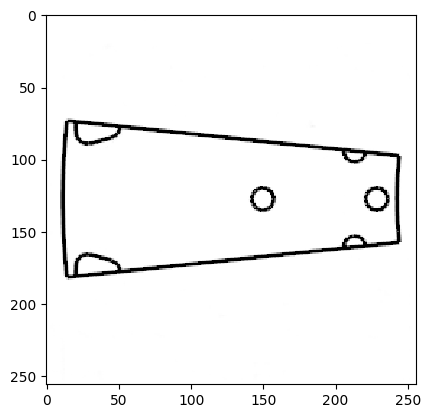

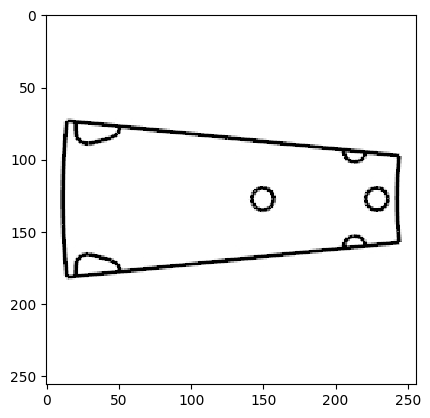

In [16]:
pred = model.predict(X_train[:3])
plt.imshow(pred[0], interpolation='nearest', cmap='gray')
plt.show()
plt.imshow(Y_train[0], interpolation='nearest', cmap='gray')
plt.show()

1/1 [==============================] - 3s 3s/step


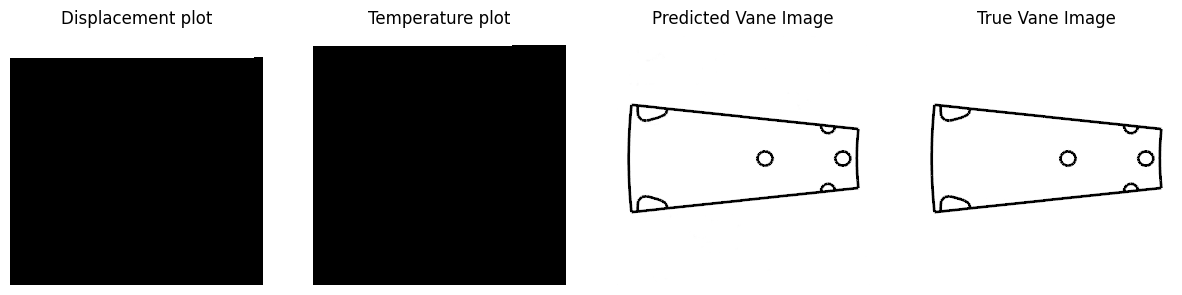

1/1 [==============================] - 0s 19ms/step


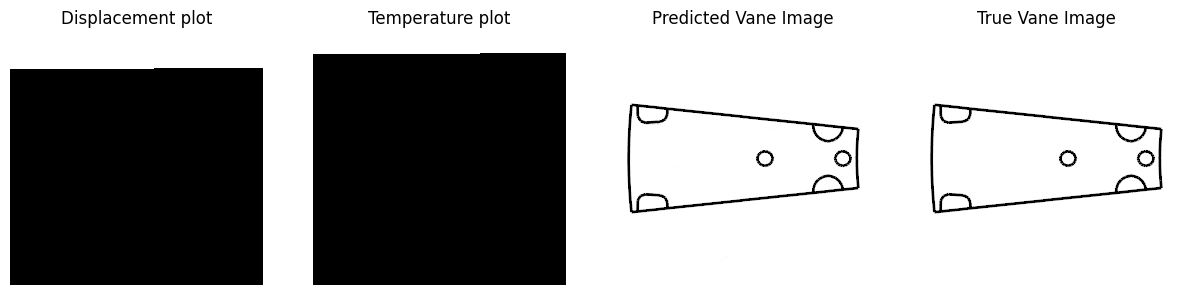

1/1 [==============================] - 0s 18ms/step


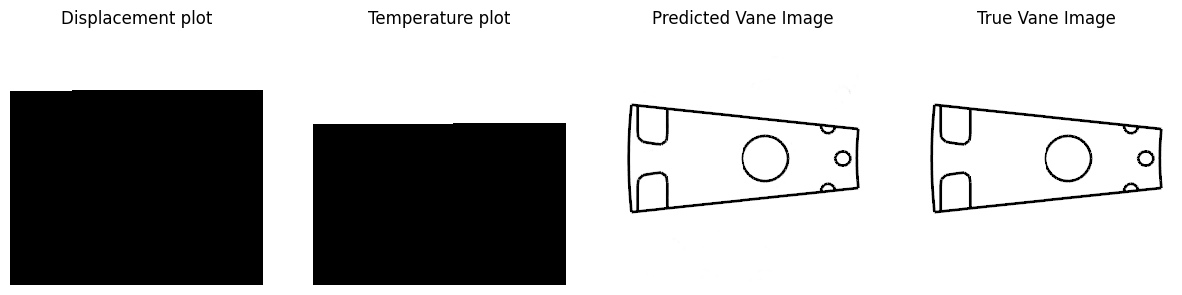

1/1 [==============================] - 0s 23ms/step


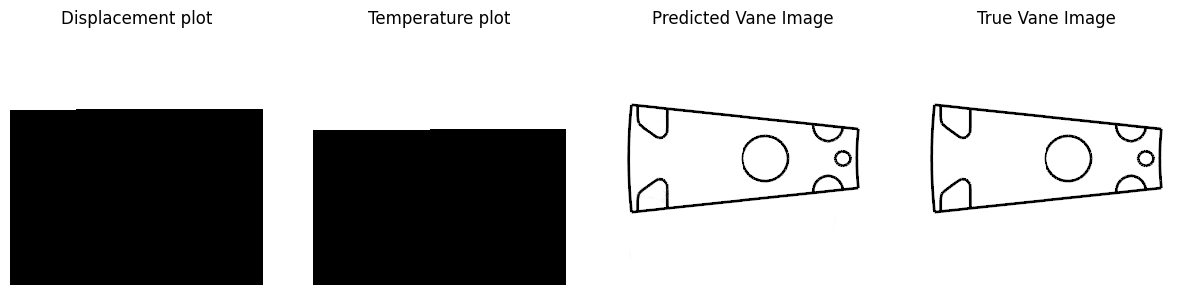

1/1 [==============================] - 0s 19ms/step


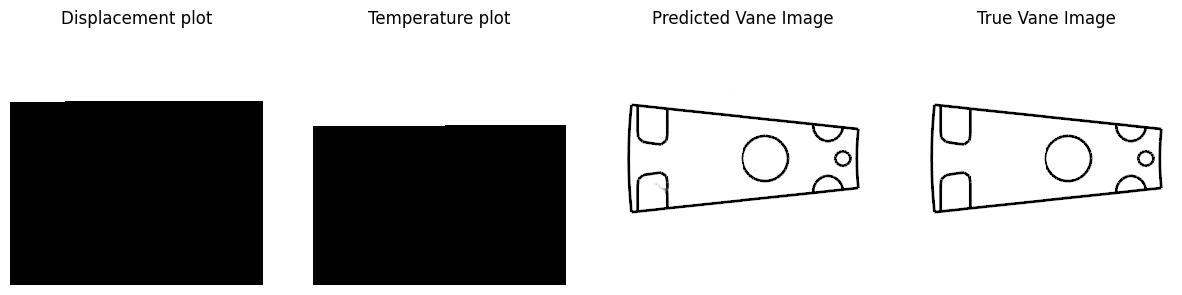

In [17]:
for i in range (5):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 4, 1)
    plt.imshow(X_train[i, :, :, 0], interpolation="nearest", cmap="gray")
    plt.title("Displacement plot")
    plt.axis(False)
    plt.subplot(1, 4, 2)
    plt.imshow(X_train[i, :, :, 1], interpolation="nearest", cmap="gray")
    plt.title("Temperature plot")
    plt.axis(False)
    plt.subplot(1, 4, 3)
    plt.imshow(model.predict(X_train[:5])[i], interpolation="nearest", cmap="gray")
    plt.title("Predicted Vane Image")
    plt.axis(False)
    plt.subplot(1, 4, 4)
    plt.imshow(Y_train[i], interpolation="nearest", cmap="gray")
    plt.title("True Vane Image")
    plt.axis(False)
    plt.show()

In [ ]:
model.save('iteration5_500epochs.h5')

1/1 [==============================] - 0s 22ms/step


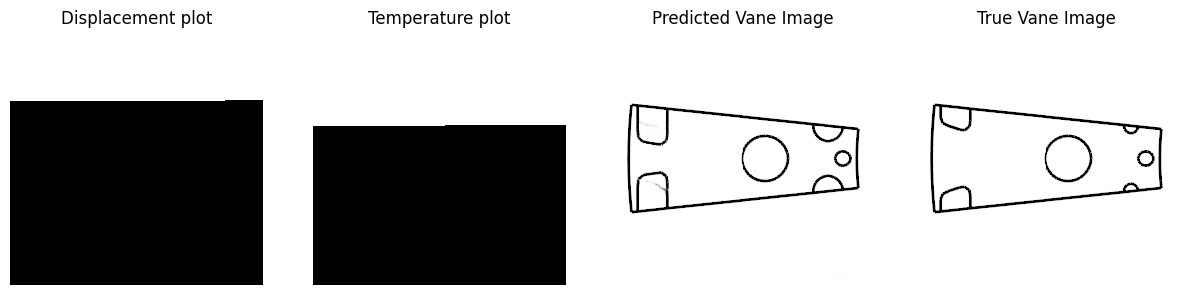

1/1 [==============================] - 0s 19ms/step


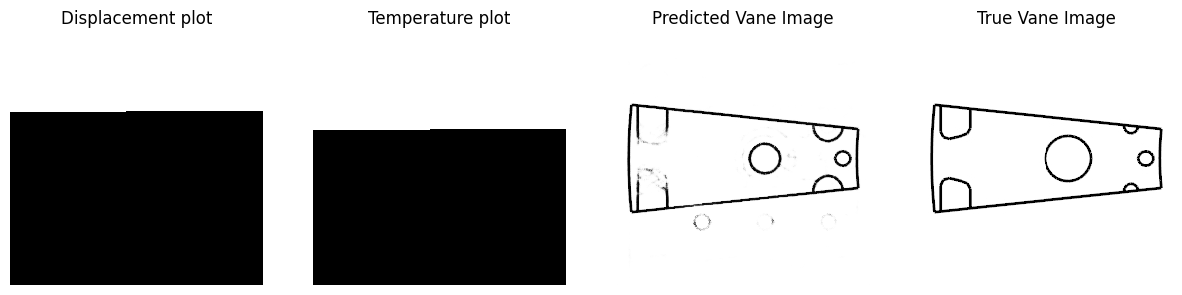

1/1 [==============================] - 0s 22ms/step


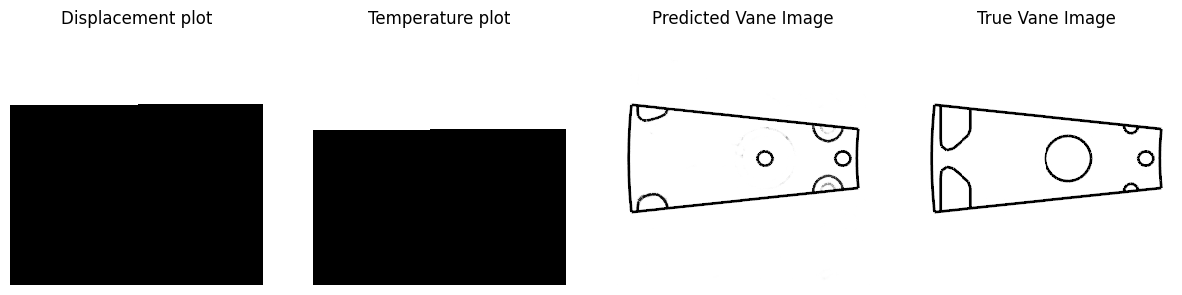

1/1 [==============================] - 0s 22ms/step


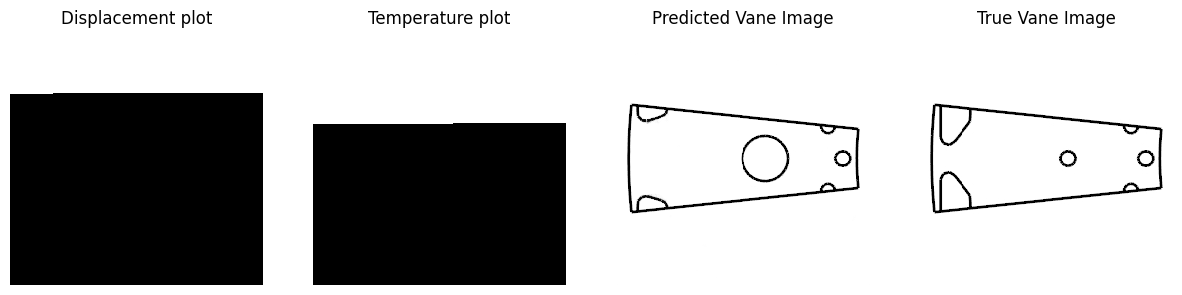

1/1 [==============================] - 0s 20ms/step


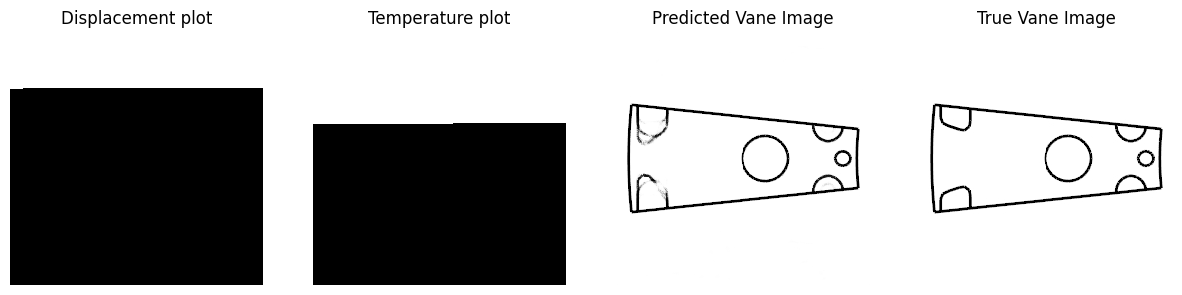

In [18]:
for i in range (5):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 4, 1)
    plt.imshow(X_test[i, :, :, 0], interpolation="nearest", cmap="gray")
    plt.title("Displacement plot")
    plt.axis(False)
    plt.subplot(1, 4, 2)
    plt.imshow(X_test[i, :, :, 1], interpolation="nearest", cmap="gray")
    plt.title("Temperature plot")
    plt.axis(False)
    plt.subplot(1, 4, 3)
    plt.imshow(model.predict(X_test[:5])[i], interpolation="nearest", cmap="gray")
    plt.title("Predicted Vane Image")
    plt.axis(False)
    plt.subplot(1, 4, 4)
    plt.imshow(Y_test[i], interpolation="nearest", cmap="gray")
    plt.title("True Vane Image")
    plt.axis(False)
    plt.show()

In [ ]:
x_train_dsp_folder_path